In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.manifold import TSNE
import torch
import torch.nn as nn

## Plotting function

In [ ]:
def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()

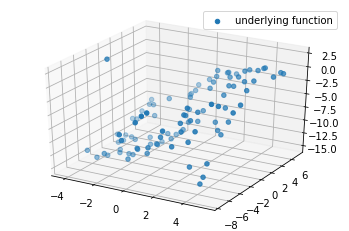

In [ ]:
bias_true = torch.FloatTensor([1,-1])
x = rand_tensor = torch.rand((100, 3))
x.requires_grad_(True)

weights_1 = torch.FloatTensor([[1, 1,0],[1,0,1]]).T
weights_2 = torch.FloatTensor([[0,0,1],[0,1,0]]).T

y_true = torch.matmul(torch.square(x) , weights_1) +  torch.matmul(x , weights_2) + bias_true
X_embedded = TSNE(n_components=2).fit_transform(x.detach())
y_embedded = TSNE(n_components=1).fit_transform(y_true.detach())
plot_3d(X_embedded, y_embedded)

## Loss function and Linear layer

In [ ]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient

class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = torch.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = torch.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = torch.square(x)@ self.weights + x @ self.weights + self.bias
    return output

  # dy/dx = 2*x*weights_true + weights_true
  # dy/dw = x2 + x
  # dy/db = 1
  def backward(self, gradient):
    self.weights_gradient = (torch.square(self.x) + self.x).T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

## Relu layer

In [ ]:
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = torch.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient

## Defining model

In [ ]:
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, 6)
    self.relu = Relu()
    self.linear2 = Linear(6, 4)
    self.relu2 = Relu()
    self.linear3 = Linear(4, 2)

  def __call__(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3
  
  def backward(self, output_gradient):

    linear3_gradient = self.linear3.backward(output_gradient)
    relu_gradient = self.relu2.backward(linear3_gradient)

    linear2_gradient = self.linear2.backward(relu_gradient)
    relu2_gradient = self.relu.backward(linear2_gradient)

    linear1_gradient = self.linear1.backward(relu2_gradient)
    return linear3_gradient

  def update(self, lr):
    self.linear3.update(lr)
    self.linear2.update(lr)
    self.linear1.update(lr)

loss = MSE()
model = Model(3, 1)
y_pred = model(x)
print(y_pred.shape)
loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()
print(loss_value)
model.backward(loss_gradient)

# y_pred_embedded = TSNE(n_components=1).fit_transform(y_pred_tensor)
# X_embedded = TSNE(n_components=2).fit_transform(x_tensor)
# y_embedded = TSNE(n_components=1).fit_transform(y_true_tensor)
# plot_3d(X_embedded, y_embedded,y_pred_embedded)

torch.Size([100, 2])
tensor(1465.5803, grad_fn=<MeanBackward0>)


tensor([[-6.5861e-04,  1.5242e-02, -2.6246e-02,  5.6875e-02],
        [-6.2691e-03,  1.7775e-02, -4.4845e-02,  9.1594e-02],
        [-4.2936e-03,  2.2543e-02, -4.7409e-02,  9.9366e-02],
        [ 2.0454e-02,  1.0186e-01, -1.1107e-01,  2.6592e-01],
        [ 4.2082e-02,  3.4020e-01, -4.3884e-01,  1.0086e+00],
        [ 1.4455e-02,  8.8270e-02, -1.0471e-01,  2.4546e-01],
        [-4.8333e-03,  2.7145e-02, -5.6217e-02,  1.1811e-01],
        [-8.1690e-03,  2.1133e-02, -5.5169e-02,  1.1219e-01],
        [-3.5056e-03,  2.9955e-02, -5.7304e-02,  1.2193e-01],
        [ 5.3442e-03,  5.3769e-02, -7.2742e-02,  1.6542e-01],
        [ 3.0701e-02,  1.6892e-01, -1.9252e-01,  4.5578e-01],
        [-2.6108e-03,  9.3327e-02, -1.5702e-01,  3.4172e-01],
        [-1.6970e-03,  2.4696e-02, -4.4155e-02,  9.5046e-02],
        [ 2.2771e-04,  5.0551e-02, -8.0804e-02,  1.7755e-01],
        [ 2.1269e-03,  7.4202e-02, -1.1397e-01,  2.5238e-01],
        [-5.4986e-03,  1.9091e-02, -4.4970e-02,  9.2706e-02],
        

## Training

In [ ]:
num_epochs=70
lr=0.02
for epoch in range(num_epochs):
    if x is not None:
      x.grad.zero_()
    y_pred = model(x)
    loss_value = loss(y_pred, y_true)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss_value.backward(retain_graph=True)
    model.backward(gradient_from_loss)
    model.update(lr)

Epoch 0, loss 1465.580322265625
Epoch 1, loss 1.6114834547042847
Epoch 2, loss 1.4676977396011353
Epoch 3, loss 1.337222695350647
Epoch 4, loss 1.218827486038208
Epoch 5, loss 1.1114609241485596
Epoch 6, loss 1.0142226219177246
Epoch 7, loss 0.9263343811035156
Epoch 8, loss 0.8471090197563171
Epoch 9, loss 0.7759254574775696
Epoch 10, loss 0.7122066617012024
Epoch 11, loss 0.6554038524627686
Epoch 12, loss 0.6049852967262268
Epoch 13, loss 0.5604305863380432
Epoch 14, loss 0.5212288498878479
Epoch 15, loss 0.48688045144081116
Epoch 16, loss 0.45690035820007324
Epoch 17, loss 0.4308241903781891
Epoch 18, loss 0.40821197628974915
Epoch 19, loss 0.3886529803276062
Epoch 20, loss 0.37176913022994995
Epoch 21, loss 0.3572167456150055
Epoch 22, loss 0.3446870446205139
Epoch 23, loss 0.33390557765960693
Epoch 24, loss 0.32463058829307556
Epoch 25, loss 0.3166510760784149
Epoch 26, loss 0.30978381633758545
Epoch 27, loss 0.3038704991340637
Epoch 28, loss 0.29877516627311707
Epoch 29, loss 0.29

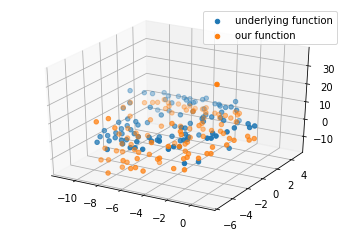

In [ ]:
y_pred= model(x).detach()
y_pred_embedded = TSNE(n_components=1).fit_transform(y_pred)
X_embedded = TSNE(n_components=2).fit_transform(x.detach())
y_embedded = TSNE(n_components=1).fit_transform(y_true.detach())
plot_3d(X_embedded, y_embedded,y_pred_embedded)